# Sales Performance Analysis for Product Insights
<p align="center"><strong>Author: Anthonia, Tool: Panda, SQL</strong></p>

In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import io
import re

## Load data

In [3]:
raw_df = pd.read_csv("sales_historical_data.csv") #
raw_df.head()

,Order ID,Amount,Profit,Quantity,Category,Sub-Category,PaymentMode,Order Date,CustomerName,State,City,Year-Month
0,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2023-06-27,David Padilla,Florida,Miami,2023-06
1,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2024-12-27,Connor Morgan,Illinois,Chicago,2024-12
2,B-26776,9726,1275,5,Electronics,Electronic Games,UPI,2021-07-25,Robert Stone,New York,Buffalo,2021-07
3,B-26776,4975,1330,14,Electronics,Printers,UPI,2023-06-27,David Padilla,Florida,Miami,2023-06
4,B-26776,4975,1330,14,Electronics,Printers,UPI,2024-12-27,Connor Morgan,Illinois,Chicago,2024-12


### Understanding dataset

| **Column Name**   | **Description**                                                                 |
|-------------------|----------------------------------------------------------------------------------|
| Order ID          |Identifier for each order line.                                               |
| Amount            | **Total sale value** of the order (includes both cost and profit).              |
| Profit            | Profit earned from the order (i.e., `Amount - Cost`).         
| Quantity          | Number of items sold in the order.                                              |
| Category          | Broad classification of the product (e.g., Electronics).                        |
| Sub-Category      | Specific type of product within the category (e.g., Printers, Electronic Games).|
| PaymentMode       | Payment method used (e.g., UPI, Credit Card).                                   |
| Order Date        | Date when the order was placed.                                                 |
| CustomerName      | Name of the customer who placed the order.                                      |
| State             | State where the order was delivered.                                            |

Order ID isnt unique as same ID is assigned to different customers . This will be renamed to **orderlineID** and a new surrogate key used as the primary key to prevent failure into db table.


## Data-Preprocessing

In [4]:
orders_df = raw_df.copy()
print(f"✅ Loaded {len(orders_df)} rows and {len(orders_df.columns)} columns.")

✅ Loaded 1194 rows and 12 columns.


### Step 2: Standardize column names to snake_case

In [8]:
def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize DataFrame column names:
    - If the column has underscores, assume it's already snake_case and just lowercase it.
    - Otherwise, convert camelCase, PascalCase, or space-separated to snake_case.
    """
    def clean_name(name: str) -> str:
        if '_' in name:
            return name.lower()
        # Convert to snake_case
        name = re.sub(r"[\s\-]+", "_", name)  # Replace spaces and hyphens with underscore
        name = re.sub(r"(.)([A-Z][a-z]+)", r"\1_\2", name)  # camelCase to snake
        name = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", name)  # PascalCase to snake
        name = re.sub(r"__+", "_", name)  # Collapse multiple underscores
        name = re.sub(r"[^\w_]", "", name)  # Remove non-alphanumeric

        return name.lower()

    df.columns = [clean_name(col) for col in df.columns]
    return df


In [11]:
# Step 2: Standardize column names to snake_case
print(" Step 2: Standardizing column names...")
orders_df = standardize_column_names(orders_df)
print(f"✅ Columns after cleaning: {list(orders_df.columns)}")

 Step 2: Standardizing column names...
✅ Columns after cleaning: ['order_id', 'amount', 'profit', 'quantity', 'category', 'sub_category', 'payment_mode', 'order_date', 'customer_name', 'state', 'city', 'year_month']


### Step 3: Handle missing values in critical fields

In [12]:
critical_cols = ["order_id"]
print(f" Step 3: Dropping rows with nulls in {critical_cols}...")
orders_df = orders_df.dropna(subset=critical_cols)
print(f"✅ Remaining rows: {len(orders_df)}")

 Step 3: Dropping rows with nulls in ['order_id']...
✅ Remaining rows: 1194


### Step 4: Convert date fields

In [13]:
print(" Step 4: Converting 'order_date' and year_month'  to datetime...")
orders_df["order_date"] = pd.to_datetime(orders_df["order_date"], errors="coerce")
orders_df["year_month"] = pd.to_datetime(orders_df["year_month"], format="%Y-%m")

before = len(orders_df)
orders_df = orders_df.dropna(subset=["order_date"])
print(f"✅ Converted. Dropped {before - len(orders_df)} rows with invalid dates.")

 Step 4: Converting 'order_date' and year_month'  to datetime...
✅ Converted. Dropped 0 rows with invalid dates.


### Step 5: Remove full duplicates (across all columns)

In [14]:
print(" Step 5: Removing full duplicate rows (based on all columns)...")
before = len(orders_df)
orders_df = orders_df.drop_duplicates()
print(f"✅ Removed {before - len(orders_df)} full duplicate rows.")

 Step 5: Removing full duplicate rows (based on all columns)...
✅ Removed 0 full duplicate rows.


### Step 6: Standardize object columns (text cleanup) with non-ID categorical fields

In [15]:
print("Step 6: Standardizing categorical fields (excluding ID columns)...")
categorical_cols = [
    col for col in orders_df.select_dtypes(include=["object", "string"]).columns
    if "id" not in col.lower()
]

for col in categorical_cols:
    orders_df[col] = orders_df[col].astype(str).str.strip().str.lower()

print(f"✅ Standardized fields: {categorical_cols}")


Step 6: Standardizing categorical fields (excluding ID columns)...
✅ Standardized fields: ['category', 'sub_category', 'payment_mode', 'customer_name', 'state', 'city']


In [16]:
# Show unique values per column
exclude_cols = ["customer_name"]
filtered_cols = [col for col in categorical_cols if col not in exclude_cols]

for col in filtered_cols:
    print(f"\n🔎 Unique values in '{col}':")
    print(orders_df[col].unique())


🔎 Unique values in 'category':
['electronics' 'office supplies' 'furniture']

🔎 Unique values in 'sub_category':
['electronic games' 'printers' 'pens' 'laptops' 'tables' 'chairs'
 'markers' 'sofas' 'paper' 'binders' 'phones' 'bookcases']

🔎 Unique values in 'payment_mode':
['upi' 'debit card' 'emi' 'credit card' 'cod']

🔎 Unique values in 'state':
['florida' 'illinois' 'new york' 'california' 'texas' 'ohio']

🔎 Unique values in 'city':
['miami' 'chicago' 'buffalo' 'orlando' 'los angeles' 'new york city'
 'springfield' 'rochester' 'dallas' 'san diego' 'austin' 'san francisco'
 'columbus' 'cincinnati' 'cleveland' 'houston' 'tampa' 'peoria']


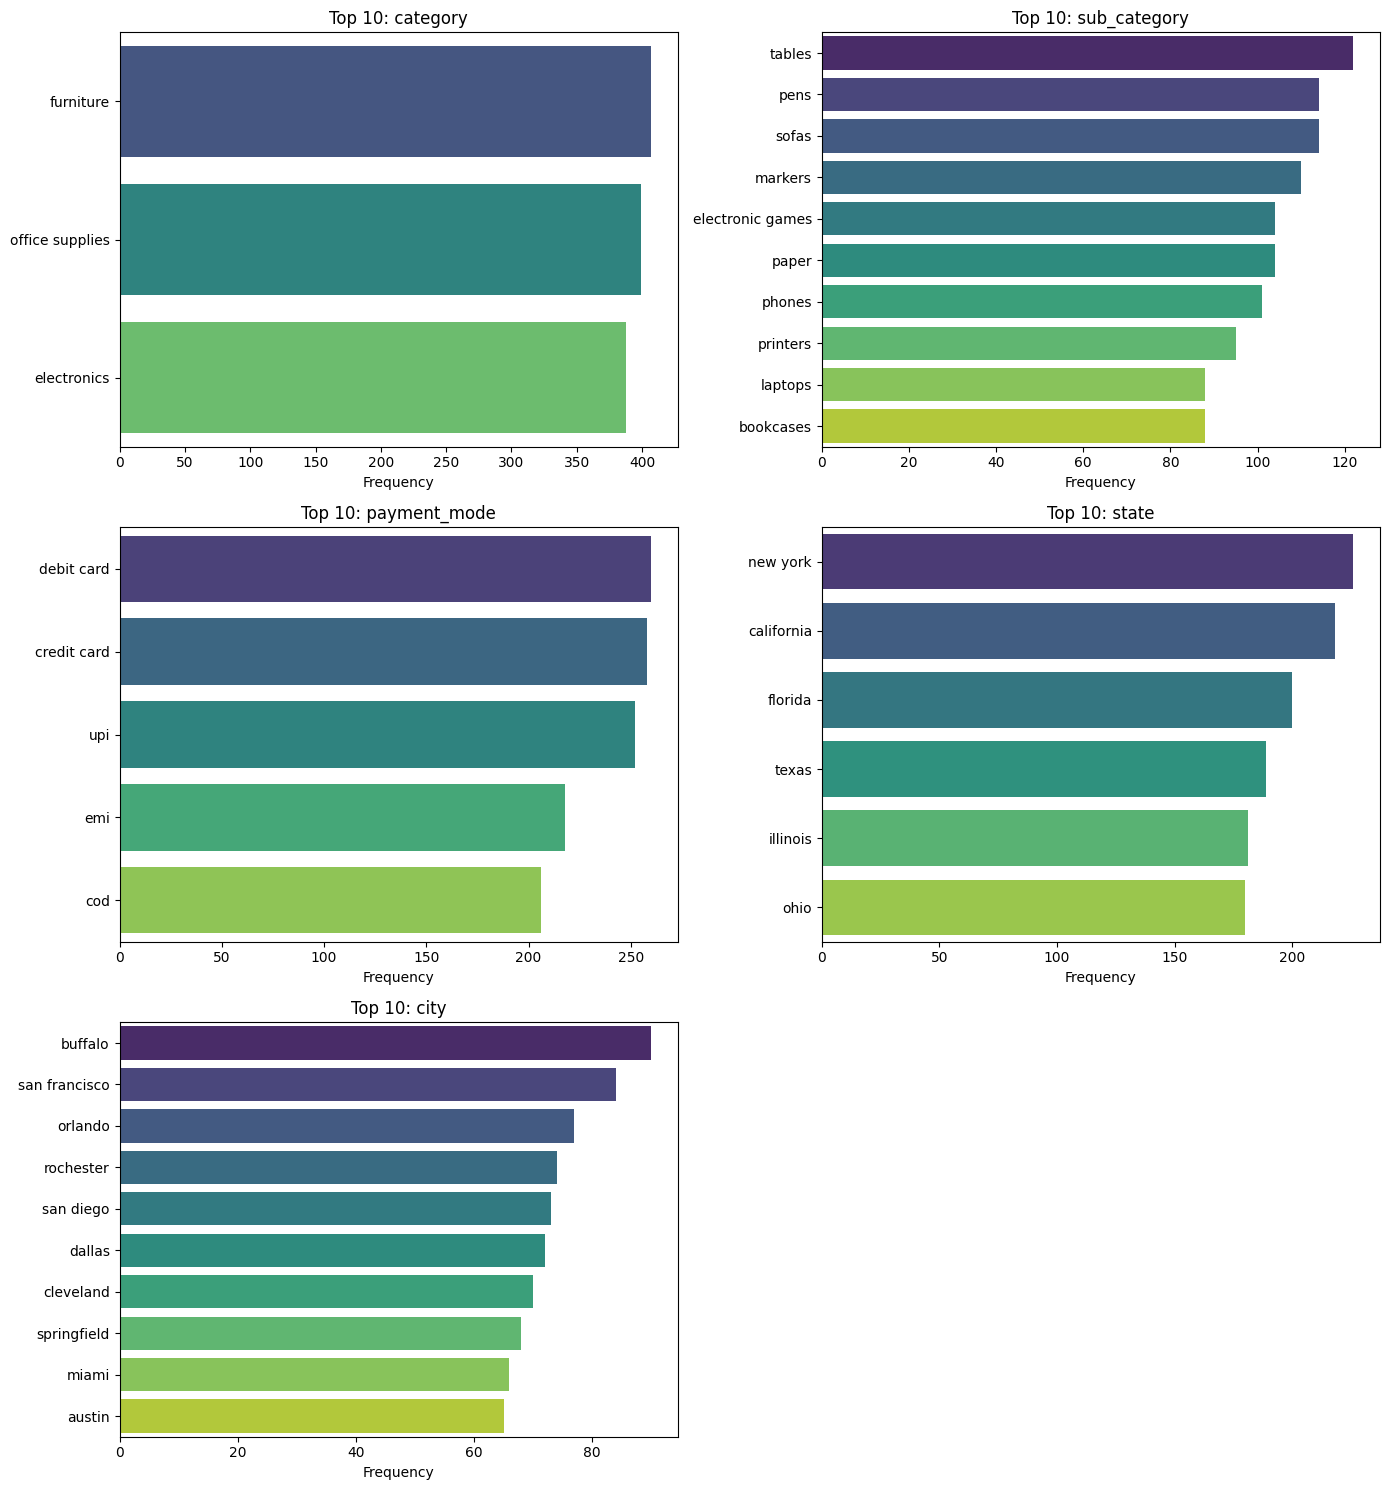

In [24]:
# Plot top 10 values for each categorical column
fig, axes = plt.subplots((len(filtered_cols) + 1) // 2, 2, figsize=(14, 5 * ((len(filtered_cols) + 1) // 2)))
axes = axes.flatten()

for i, col in enumerate(filtered_cols):
    counts = orders_df[col].value_counts().head(10)
    sns.barplot(x=counts.values, y=counts.index, hue=counts.index, ax=axes[i], palette="viridis", legend=False)
    axes[i].set_title(f"Top 10: {col}")
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("")
    
    # Hide unused subplots
    if i == len(filtered_cols) - 1:
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Step 7: Split 'customername' into 'first_name' and 'last_name'

In [25]:
print(" Step 7: Splitting 'customer_name' into 'first_name' and 'last_name'...")
orders_df[["first_name", "last_name"]] = orders_df["customer_name"].str.strip().str.split(" ", n=1, expand=True)
print("✅ Name split complete.")

 Step 7: Splitting 'customer_name' into 'first_name' and 'last_name'...
✅ Name split complete.


### Step 8: Add derived field 'cost'

In [26]:
print(" Step 8: Calculating 'cost' = amount - profit...")
orders_df["cost"] = (orders_df["amount"] - orders_df["profit"]).round(2)
print("✅ cost column added.")

 Step 8: Calculating 'cost' = amount - profit...
✅ cost column added.


### Step 9: Rename 'order_id' to 'orderline_id'

In [28]:
orders_df.rename(columns={"order_id": "orderline_id"}, inplace=True)
print(" Step 9: order_id column renamed to 'orderline_id' ")

 Step 9: order_id column renamed to 'orderline_id' 


### Step 10: Add surrogate key ===

In [29]:
orders_df.insert(0, "order_sk", range(1, len(orders_df) + 1))
print(" Step 10: Surrogate key order_sk added as primary key for 'orders' table...")

 Step 10: Surrogate key order_sk added as primary key for 'orders' table...


### Step 11: Final table for orders

In [30]:
print(" Step 11: Preparing final cleaned DataFrame for 'orders' table...")
orders_df = orders_df[
    ["order_sk", "orderline_id", "amount", "profit", "cost", "quantity", "order_date","year_month",
     "payment_mode", "first_name", "last_name", "state", "city", "category", "sub_category"]
].copy()
print(f" Final cleaned dataset ready with {len(orders_df)} rows.")

dtype_df = pd.DataFrame({
    "column": orders_df.columns,
    "dtype": [str(dtype) for dtype in orders_df.dtypes]
})
from IPython.display import display
display(dtype_df)


 Step 11: Preparing final cleaned DataFrame for 'orders' table...
 Final cleaned dataset ready with 1194 rows.


,column,dtype
0,order_sk,int64
1,orderline_id,object
2,amount,int64
3,profit,int64
4,cost,int64
5,quantity,int64
6,order_date,datetime64[ns]
7,year_month,datetime64[ns]
8,payment_mode,object
9,first_name,object


## Save cleaned df to file (optional)

In [20]:
orders_df.to_csv("retailx_orders_cleaned.csv", index=False)
print(" Cleaned file saved as 'retailx_orders_cleaned.csv'")

 Cleaned file saved as 'retailx_orders_cleaned.csv'


## Load Cleaned Data into pgAdmin with Error Handling

###  Step 1: Connect to PostgreSQL

In [25]:
conn = get_db_connection(env_prefix="SALES_DB_")  # uses default prefix DB_
cur = conn.cursor()
print("✅ Connected to PostgreSQL")

[get_db_connection] ✅ Connected to 'user=postgres password=xxx dbname=retailx_db host=localhost port=5432' using prefix 'SALES_DB_'
✅ Connected to PostgreSQL


###  Step 2: Schema + Table Creation with Error Handling

In [26]:
try:
    cur.execute("CREATE SCHEMA IF NOT EXISTS retailx_oltp;")
    
    cur.execute("""
    CREATE TABLE IF NOT EXISTS retailx_oltp.orders (
        order_sk INT PRIMARY KEY,
        orderline_id TEXT,
        amount DOUBLE PRECISION,
        profit DOUBLE PRECISION,
        cost DOUBLE PRECISION,
        quantity INT,
        order_date DATE,
        year_month DATE,
        payment_mode TEXT,
        first_name TEXT,
        last_name TEXT,
        state TEXT,
        city TEXT,
        category TEXT,
        sub_category TEXT
    );
    """)
    conn.commit()
    print("✅ Schema and table created.")
except Exception as e:
    conn.rollback()
    print(f"❌ Failed to create schema or table: {e}")

✅ Schema and table created.


### Step 3: Load Data Using copy_expert with Error Handling

In [27]:
try:
    print("Loading data into PostgreSQL using buffer...")
    buffer = io.StringIO()
    orders_df.to_csv(buffer, index=False, header=False)
    buffer.seek(0)

    cur.copy_expert(
        """
        COPY retailx_oltp.orders (
            order_sk, orderline_id, amount, profit, cost, quantity, order_date,year_month,
            payment_mode, first_name, last_name, state, city,
            category, sub_category
        ) FROM STDIN WITH (FORMAT CSV)
        """, buffer
    )
    conn.commit()
    print("✅ Data loaded into table.")
except Exception as e:
    conn.rollback()
    print(f"❌ Data load failed: {e}")

Loading data into PostgreSQL using buffer...
✅ Data loaded into table.


### Step 4: verify load success

In [28]:

try:
    query = "SELECT * FROM retailx_oltp.orders LIMIT 10;"
    df = pd.read_sql_query(query, conn)
    print("✅ Query executed successfully.")
except Exception as e:
    print(f"❌ Failed to execute query: {e}")
df.head(3)

✅ Query executed successfully.


C:\Users\Probook\AppData\Local\Temp\ipykernel_37628\444601185.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,order_sk,orderline_id,amount,profit,cost,quantity,order_date,year_month,payment_mode,first_name,last_name,state,city,category,sub_category
0,1,B-26776,9726.0,1275.0,8451.0,5,2023-06-27,2023-06-01,upi,david,padilla,florida,miami,electronics,electronic games
1,2,B-26776,9726.0,1275.0,8451.0,5,2024-12-27,2024-12-01,upi,connor,morgan,illinois,chicago,electronics,electronic games
2,3,B-26776,9726.0,1275.0,8451.0,5,2021-07-25,2021-07-01,upi,robert,stone,new york,buffalo,electronics,electronic games


###  Step 5: Final Cleanup

In [29]:
cur.close()
conn.close()
print("Connection closed.")

Connection closed.


## Analysis

In [ ]:
script = "retailx_dashboard_queries.sql"
dashboard_views = "retailx_dashboard_views.json"

### Outcome Summary

#### 1. Top 5 selling products by quantity (using sub_category as product identifier)

![top5_products](charts/top5_products.png)

Tables top the sales volume (**1,306 units**), followed closely by **sofas (1,258 units)** and **electronic games (1,240 units)**. These represent high-demand categories, ideal for promotional bundling, stock optimization, and inventory prioritization

#### 2. Total revenue per product

![total_revenue_per_product](charts/total_revenue_per_product.png)

`Markers` lead in revenue (`£630,428`)**, just ahead of **tables (`£627,585`)** and **sofas (`£578,789`)**. Despite not topping the quantity chart, markers likely benefit from **higher unit prices** or **bulk sales**, making them a key profit driver. Furniture and electronics — such as **printers (`£568,943`)** and **electronic games (`£568,711`)** — are also top-performing revenue categories, supporting strategic focus on these product lines.

#### 3.  Regional Sales Insight (Sales performance by state)

![Regional Sales](charts/salesperf_states.png)

**Top States by Sales:**
- **New York** — `£1.13M` from 226 orders
- **Florida** — `£1.09M` from 200 orders
- **California** — `£1.08M` from 218 orders

*High sales are concentrated in large, populous states, highlighting the influence of **regional demand** and **urban market density**. These states are ideal targets for **geo-focused campaigns** and **regional inventory strategies** to maximizegrowth*

#### 4. Customers contributing most to revenue?

![top_customers](charts/top_customers.png)

The top 10 customers are high-value contributors, each generating over `$23,000` in revenue.

- `Cory Evans` — `$28,440`  
- `Nicholas Anderson` — `$27,680`  
- `Emily Ellison` — `$27,500`  
- Other top customers include:  
  `George Foster`, `Katherine Williams`, `Jacqueline Harris`,  
  `Randy Johnson`, `Tammy Bell`, `Brian Green`, `Zachary Perez`

*These loyal, high-spending customers drive a substantial portion of sales. They are ideal candidates for `loyalty programs`, `exclusive deals`, or `personalized marketing` to increase lifetime value.*

#### 5. Month with the most sales?  

![year_month_trend](charts/year_month_trend.png)

![month_trend](charts/month_trend.png)

![top_salesmonth](charts/top_salesmonth.png)

 From 2020 to 2025, sales show irregular month-to-month variation, with sharp spikes in June 2022 and December 2022 (each over £200,000)
- Aggregated by calendar month, sales rise steadily from January through May, peaking around `£580,000`
- September sees a notable dip `(~£410,000)`, followed by strong recoveries in October `(~£640,000)` and December `(~£670,000)`
- `December 2022` stands out as the highest-performing single month with total sales of `£204,413` — driven by holiday season demand

#### 6. Top 5 recurring customers

![top5_rec_cust](charts/top5_rec_cust.png)

Each of these customers placed **4 repeat orders**, making them the most consistent buyers in the dataset:
- `Scott Lewis`, `Cory Evans`, `Jacqueline Harris`, `Sabrina Hartman`,`Christina Davis`  

*These customers show strong retention and engagement. They are excellent candidates for loyalty rewards, referral incentives, or early access to promotions.*

#### 7. Best performing product categories (top 5 by revenue)

![top5_prdtcateg](charts/top5_prdtcateg.png)

![top5_prdtcateg1](charts/top5_prdtcateg1.png)

- `Office Supplies` leads with **£2,089,510**
- Followed by `Electronics` at **£2,054,456**
- Then `Furniture` with **£2,038,673**

*While all three categories contribute almost equally to total revenue, **Office Supplies** has a slight edge, indicating strong, consistent demand across business needs. Balanced category performance also suggests a **diversified sales portfolio** with opportunity to optimize category-specific promotions.*


#### 8. Best performing sub-categories (top 5 by revenue)

![top5_subcat](charts/top5_subcat.png)

![top5_subcat1](charts/top5_subcat1.png)

- `Markers` lead with `627,875`
- Followed closely by `Tables` at `625,177`
- `Sofas`, `Printers`, and `Electronic Games` all generate over `565,000` each

*These top sub-categories represent strong revenue streams across both office and home product segments. Their balanced performance indicates stable customer demand, making them ideal for continued investment in stock and targeted marketing.*

#### 9. Most frequent payment method

![payment_mode](charts/payment_mode.png)

- The most commonly used payment method is **Debit Card**, with **260 transactions**

*This highlights a strong preference for **debit-based payments** among customers, suggesting the importance of maintaining smooth, reliable debit processing and potentially offering promotions for this payment type.*


#### 10. City with the highest sales

![top_city](charts/top_city.png)

- The top-performing city is **Orlando**, with total sales of `452,158`

*This makes Orlando a strategic hub for customer demand — an ideal location for localized marketing, inventory prioritization, or future fulfillment optimization.*


## Outcome Summary Aligned with Project Objective & Problem Statement

- **Product Performance:**  
  - `Tables` topped sales volume (1,306 units), while `Markers` led in total revenue (£627K), showing that high-margin items may not always be top-selling by quantity.  
  - Sub-category performance shows balanced demand across both office and home product segments, supporting informed inventory and bundling strategies.

- **Regional & Geographic Trends:**  
  - High revenue concentrations were found in `New York (£1.13M)`, `Florida (£1.09M)`, and `California (£1.08M)`, with `Orlando (£452K)` leading all cities.  
  - These insights emphasize the need for geo-targeted marketing and localized fulfillment.

- **Customer Insights:**  
  - The top customers (e.g., `Cory Evans` – £28.4K) significantly influence revenue, while recurring buyers (e.g., `Scott Lewis`, `Christina Davis`) show high retention potential.  
  - Tailored engagement strategies such as loyalty programs and personalized offers can further boost lifetime value.

- **Time-Based Trends:**  
  - Sales patterns across `2020–2025` show seasonal peaks in `May (~£580K)` and `December (~£670K)`, with `December 2022` alone bringing in **£204,413**.  
  - These findings validate the need for seasonal campaigns and supply planning aligned with demand spikes.

- **Consumer Behavior:**  
  - `Debit Card` was the most frequent payment method (260 transactions), signaling a customer preference that can inform payment channel reliability and promotions.

## Restoring a PostgreSQL Database from a `.backup` File

# To restore the `.backup` file (custom format), ensure:

- PostgreSQL is installed and running
- The `pg_restore` tool is available in your terminal
- You know the PostgreSQL username (postgres) and have appropriate access

```bash
pg_restore -U your_user -C -d postgres retailx_backup_2024_04_17.backup

